# Quantum Control as Polynomial Optimization: Piecewise constant controls 

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [1]:
Threads.nthreads()

110

In [2]:
using LinearAlgebra
using DynamicPolynomials
using TSSOS
using SpecialFunctions
using HDF5

## Quantum system

In [3]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V ./= norm(V, Inf);

## Chebyshve polynomial approximation for $\exp(\Delta t \Omega)$

In [4]:
"""
Chebyshev approximation for exp(Δt Ω)
"""
function exp_chebyshev(Δt::Real, Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, Δt) * Tₙ₋₁ + 2 * besselj(1, Δt) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, Δt) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

In [5]:
@polyvar x[1:2]

# final time
const T = 0.5

Δt = T / size(x)[1]

𝓤 = prod(exp_chebyshev(Δt, -im * (H0 + ξ * V), 7) for ξ in x);

## Utilities

In [6]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

function scaling_poly(p::Polynomial)
    #=
    Estimate the scaling factor for the variables of a polynomial to make TSSOS computations numerically stable 
    
    see https://github.com/wangjie212/TSSOS/issues/6
    =#    
    X = transpose(hcat([exponents(t) for t in terms(p)]...))
    
    # Get the scaling via linear regression  
    scaling = X \ log.(abs.(coefficients(p)))
    
    exp.(abs.(scaling))
end

function propagate(x::AbstractArray)   
    #=
    Solve the equation of motion
    =#
    prod(exp(-im * Δt * (H0 + ξ * V)) for ξ in x)
end

function 𝓤_propagation(x::AbstractArray)   
    map(z -> z(x), 𝓤)
end

𝓤_propagation (generic function with 1 method)

## Read target unitiries

In [7]:
h5open("results.hdf5", "r") do fid
    global U_targets = read(fid["U_targets"])
    global magnus_norm_U_target_minus_obtained = read(fid["norm_U_target_minus_obtained"])
    global magnus_f_PSU = read(fid["f_PSU"]) 
end;

In [8]:
@time begin
    
n_samples = size(U_targets)[1]

# piecewise constant controls 
piecewise_const_x = zeros((n_samples, length(x)))
    
# Frobenius norm difference between target and obtained unitaries
norm_U_target_minus_obtained = zeros(n_samples)

# Difference between symbolic exponent and exact to check accuracy  
norm_𝓤_propagation_exact = zeros(n_samples)

# The normalised overlap of the evolution and the target 
f_PSU = zeros(n_samples) 
    
Threads.@threads for i=1:n_samples
    
    # target unitray
    U_target = U_targets[i, :, :]
        
    # get the polynomial objective function
    obj = square_frobenius_norm(
        U_target - 𝓤
    )
    
    # scale polynomial to make TSSOS computations numerically stable 
    scaling = scaling_poly(obj)
    obj = subs(obj, x => scaling .* x)  
        
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true, solution = true)
    
    previous_sol = sol
    previous_opt = opt
    
    while ~isnothing(sol)
        previous_sol = sol
        previous_opt = opt
            
        opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
    end

    min_x = scaling .* previous_sol

    # saving the found controls
    piecewise_const_x[i, :] = min_x
        
    # Frobenius norm difference between target and obtained unitaries
    U_obtained = propagate(min_x)
    norm_U_target_minus_obtained[i] = norm(U_target - U_obtained)
        
    # The normalised overlap of the evolution and the target 
    f_PSU[i] = abs(tr(U_target' * U_obtained)) / size(U_obtained)[1]
        
    # Difference between symbolic exponent and exact to check accuracy 
    norm_𝓤_propagation_exact[i] = norm(U_obtained - 𝓤_propagation(min_x))   
end
    
end

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************

optimum = -3.1015697269463245e-9
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = 9.147338391882806e-10
Global optimality certified!
Global optimality certified!
optimum = -8.344439975862137e-10
optimum = -3.3592303904283117e-9
Global optimality certified!
optimum = -1.5843940836648716e-9
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = -3.7140443168250036e-9
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality ce

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************

************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = -8.368305041979265e-10
optimum = -1.224254708696421e-8
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
optimum = -3.6671330335736006e-9
optimum = -3.587500504778279e-9
Global optimality certified!
optimum = 9.920481430394107e-10
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = -3.527062737664558e-9
optimum = -1.7026480244499892e-8
Global optimality certified!
No higher TSSOS hierarchy!
optimum = -1.9739210644052937e-10
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
optimum = -3.7776892386930335e-9
No higher TSSOS hierarchy!
optimum = -3.582536497649531e-9
Global optimality certified!
optimum = -4.91939

optimum = 6.251969470161625e-10
No higher TSSOS hierarchy!
optimum = -6.276864741145221e-10
Global optimality certified!
optimum = -3.0341720619862035e-9
optimum = -1.9764520874737728e-9
************************TSSOS************************
TSSOS is launching...
optimum = 9.213825218233923e-10
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = -3.4892878754655362e-9
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSS

optimum = -7.586025191492848e-9
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = -2.9441252229803703e-9
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
Global opti

optimum = 9.159289178340075e-9
optimum = -5.936096042150492e-10
Global optimality certified!
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = -3.4204221413417706e-9
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 1.0500691160438646e-8
Global optimality certified!
optimum = -1.4121679378598497e-9
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = -4.124059649380291e-9
************************TSSOS************************
TSSOS is launching...
optimum = -1.3841477921242649e-9
No higher TSSOS hierarchy

optimum = -3.497696710111284e-9
Global optimality certified!
No higher TSSOS hierarchy!
optimum = -2.173353506758137e-8
optimum = 4.385376681300446e-9
Global optimality certified!
optimum = -3.037289944193887e-9
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = -9.95939549995649e-11
Global optimality certified!
optimum = -2.3653496308333048e-9
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = -3.2636260179422996e-9
optimum = -1.8419742580825231e-9
optimum = -3.33242735729648e-9
optimum = -3.631037691552386e-9
optimum = -2.1015897719409106e-9
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = 4.704024765524793e-10
************************TSSOS***************

optimum = -1.8387399735721971e-9
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = -2.3403108383535336e-9
optimum = -7.695076144242623e-10
optimum = -1.6401496667109621e-9
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = -3.4229265850022774e-10
optimum = -3.4347188725627553e-9
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
optimum = -2.3468817969067976e-9
optimum = -5.489441926025703e-9
Global opti

optimum = -6.098646138120727e-9
optimum = -1.9415184736762555e-9
optimum = -2.9078431296551292e-9
optimum = -1.3686930636715976e-9
optimum = -1.1102218960589729e-8
Global optimality certified!
optimum = -8.889016046231739e-10
optimum = -1.4945469559896514e-8
optimum = -3.947305500673451e-9
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
Global optimality certified!
optimum = -2.5212359040461492e-9
optimum = -2.1174668056050415e-9
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = -3.579818901986093e-9
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher 

TSSOS is launching...
optimum = -4.687041368455178e-9
Global optimality certified!
************************TSSOS************************
No higher TSSOS hierarchy!
Global optimality certified!
TSSOS is launching...
Global optimality certified!
TSSOS is launching...
optimum = 8.226675113614065e-9
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
optimum = -4.8850446724802045e-9
TSSOS is launching...
optimum = -5.528065136026284e-9
************************TSSOS************************
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
************************TSSOS************************
Global optimality certified!
************************TSSOS************************
Global optimality certified!
Global optimality certified!
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = -2.7497200989431257e-9
No higher TSSOS hierarchy!
Global optimality certified!
TSSOS is launching...
optimum = -7.085809

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = -3.0674293863097856e-9
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 1.4599102575785635e-9
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = -1.7146442695671568e-9
No higher TSSOS hierarchy!
optimum = -3.4175428145754822e-9
Global optimality certified!
Global optimality certified!
optimum = 1.1130390027302484e-9
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS*

## Save results

In [9]:
h5open("results_PiecewiseConst.hdf5", "w") do fid
    fid["U_targets"] = U_targets
    fid["piecewise_const_x"] = piecewise_const_x
    fid["f_PSU"] = f_PSU
    fid["norm_U_target_minus_obtained"] = norm_U_target_minus_obtained
end;

## Analysis

In [10]:
using PyPlot

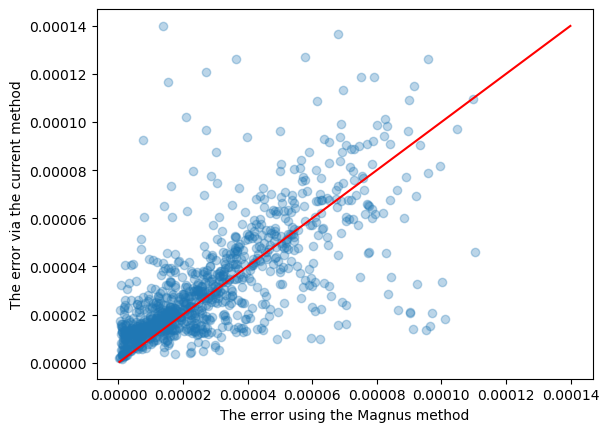

In [11]:
scatter(magnus_norm_U_target_minus_obtained, norm_U_target_minus_obtained, alpha=0.3)

lower = min(minimum(magnus_norm_U_target_minus_obtained), minimum(norm_U_target_minus_obtained))
higher = max(maximum(magnus_norm_U_target_minus_obtained), maximum(norm_U_target_minus_obtained))
plot([lower, higher], [lower, higher], "r")

xlabel("The error using the Magnus method")
ylabel("The error via the current method")
show()

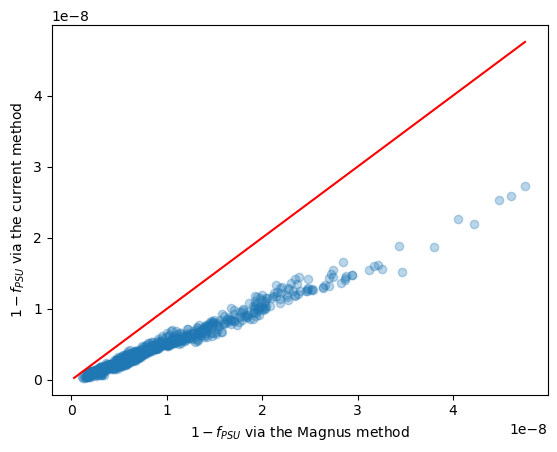

In [12]:
magnus_ε = 1 .- magnus_f_PSU
ε = 1 .- f_PSU

scatter(magnus_ε, ε,  alpha=0.3)

lower = min(minimum(magnus_ε), minimum(ε))
higher = max(maximum(magnus_ε), maximum(ε))
plot([lower, higher], [lower, higher], "r")

xlabel(L"1 - f_{PSU}" * " via the Magnus method")
ylabel(L"1 - f_{PSU}" * " via the current method")
show()